In [1]:
import copy
import pickle

import polars as pl
import pandas as pd
import polars.selectors as cs

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

import catboost as cb
from catboost import CatBoostClassifier


import matplotlib.pyplot as plt

from modules.utils import data_utils, plot_utils
from modules.types.constants_sedds import FeatureCategory

In [2]:
data = data_utils.load_data()

In [3]:
data.describe()

statistic,progressed,size,PDI,API_prop,oil_total,surfactant_total,cosolvent_total,other_total,o_num,s_num,c_num,other_num,cplx_minmax_norm,API_mol_wt,logp_chemaxon,API_melt_temp,API_water_sol,API_polar_sa,API_rot_bond,API_H_bond_donor,API_H_bond_accept,o_LC,o_sat,s_HLB,c_mol_wt,c_melt_temp,c_boil_temp,c_density,c_viscosity
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,f64,f64,f64,f64,f64,f64
"""count""","""668""",506.0,289.0,668.0,668.0,668.0,668.0,668.0,668.0,668.0,668.0,668.0,668.0,668.0,668.0,668.0,668.0,668.0,668.0,668.0,668.0,"""668""","""668""",668.0,668.0,668.0,668.0,668.0,668.0
"""null_count""","""0""",162.0,379.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""0""","""0""",0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",null,140.205658,0.250784,6.415936,35.014633,45.269371,12.147912,1.152695,1.368263,1.288922,0.646707,0.091317,0.174401,481.722534,4.733294,130.891464,0.057113,95.349953,8.296407,1.73503,4.547904,null,null,13.642815,78.044014,-42.598801,97.270958,0.582036,13.658234
"""std""",null,304.983734,0.146898,6.055097,21.0464,20.49094,15.289106,6.349833,0.560316,0.625828,0.551164,0.308378,0.109052,229.726608,1.685694,48.424789,0.175672,74.825226,3.715382,1.995535,3.195637,null,null,2.526405,105.660721,47.233089,92.058823,0.472266,27.431568
"""min""",null,7.2,0.02,0.06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.289993,-2.3,59.5,0.00011,6.48,0.0,0.0,2.0,null,null,0.0,0.0,-114.099998,0.0,0.0,0.0
"""25%""",null,31.9,0.145,2.0,18.0,30.0,0.0,0.0,1.0,1.0,0.0,0.0,0.125,360.829987,3.64,80.5,0.00071,46.529999,6.0,0.0,3.0,null,null,13.0,0.0,-76.0,0.0,0.0,0.0
"""50%""",null,76.529999,0.23,5.0,33.169998,44.0,8.0,0.0,1.0,1.0,1.0,0.0,0.125,406.473999,5.22,125.5,0.0122,52.599998,7.0,1.0,3.0,null,null,14.5,46.099998,-26.0,78.400002,0.8,1.1
"""75%""",null,170.699997,0.32,8.5,50.34,61.5,19.34,0.0,2.0,2.0,1.0,0.0,0.25,500.423004,5.28,149.5,0.0234,117.68,11.0,2.0,6.0,null,null,15.0,134.199997,0.0,202.0,1.0,4.8
"""max""",null,4964.0,0.949,52.700001,99.32,97.0,76.800003,68.040001,3.0,5.0,3.0,2.0,1.0,1202.609985,8.06,232.0,0.75,319.609985,18.0,12.0,17.0,null,null,16.9,600.0,32.5,261.200012,1.2,90.0


# Exploratory analysis of the target progressed

- Main goal of the progressed exploratory analysis is to see if we can use information about the drug and excipients to predict whether the formula will be promising before performing real experiment and our target is 'progressed'. 

## Target
- The target variable describing whether the formulation was promising or not and progressed in further development.

In [4]:
target = 'progressed'

- We are excluding all SEDDS characteristics that cannot be predetermined before creating a formulation. 

- As we know dataset consist of 668 unique formulations using 20 different drugs, 44 unique oils, 31 unique surfactants, and 17 unique cosolvents.
- That means we will be analyzing only similiarities and patterns of these formulations to determine if such formulation has a chance to actually progress.


In [5]:
sedds_features = copy.copy(FeatureCategory.SEDDS.value)
sedds_features.remove(target)

- In following steps, we are constructing pipelines with various classifiers to evaluate their performance prior to conducting any feature engineering or other preprocessing steps. 
- Most effective model?


# Models

We chose several models for further analysis.

**1. Logistic Regression (logreg):**

Logistic Regression was chosen as a good baseline for understanding the relationships in the data and feature importances.

**2. PCA with Logistic Regression (pca_logreg):**

By combining PCA with logistic regression, the model may improve performance by using only the most important components of the dataset.

**3. Support Vector Machine (svm):**

SVM is a good choice as such a model can handle complex, non-linear relationships. In this case, the model uses a linear kernel in the SVC class with C=5 for robustness.

**4. Decision Tree Classifier (dt_class):**

The decision tree was chosen for its interpretability, i.e. which features are most important in determining whether a formulation progresses.

#### Train, Test dataset split

- In the next step, we will split the dataset into training and testing sets to evaluate the performance of the decision tree classifier.

- Due to the limited size of our dataset, we will not use a separate validation set and will only split the data into training and testing sets.

In [6]:
from sklearn.model_selection import train_test_split

X = data.drop([target] + sedds_features).to_dummies(cs.categorical()).to_pandas()
y = data.select(target).to_pandas()

X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.20, random_state=42)

In [7]:
categoricals = X.select_dtypes('category').columns

In [8]:
classifiers = {
    'logreg': Pipeline([
        ('fillna', SimpleImputer(strategy="median")),
        ('sc', StandardScaler()), 
        ('reg', LogisticRegression())
    ]),
    'pca_logreg': Pipeline([
        ('fillna', SimpleImputer(strategy="median")),
        ('sc', StandardScaler()),
        ('pca', PCA(n_components=0.95)), # keeping 95% of information
        ('reg', LogisticRegression())
    ]),
    'svm': Pipeline([
        ('fillna', SimpleImputer(strategy="median")),
        ('sc', StandardScaler()),
        ('svc', SVC(C = 5))
    ]),
    'dt_class': Pipeline([
        ('fillna', SimpleImputer(strategy="median")),
        ('dt', DecisionTreeClassifier(max_depth = 3, random_state=42))
    ]),
    'cb': Pipeline([
    ('onehot', ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), categoricals)  # Specify categorical columns here
        ],
        remainder='passthrough'  # other cols will be passed with no transformation
    )),
    ('fillna', SimpleImputer(strategy="median")),
    ('reg', CatBoostClassifier(iterations = 25))
])

}

#### Feature Selection
- Certain features were removed including the target and SEDDS-specific features.

- Categorical features in the data have been converted to dummy variables using one-hot encoding.

- Then target variable was extracted from the dataset.


In [9]:
X_tr.head(5)

,API_prop,oil_total,surfactant_total,cosolvent_total,other_total,o_num,s_num,c_num,other_num,API_mol_wt,...,o_LC_0,o_LC_1,o_sat_0,o_sat_1,s_HLB,c_mol_wt,c_melt_temp,c_boil_temp,c_density,c_viscosity
235,44.439999,0.00,50.000000,0.000000,5.56,0.0,2.0,0.0,1.0,435.519012,...,1,0,1,0,14.4,0.000000,0.0,0.000000,0.0,0.0
399,2.000000,67.00,28.000000,3.000000,0.00,1.0,1.0,1.0,0.0,1202.609985,...,0,1,1,0,15.0,76.099998,-59.0,188.199997,1.0,56.0
602,5.000000,19.00,38.000000,38.000000,0.00,1.0,1.0,1.0,0.0,418.559998,...,1,0,0,1,15.0,134.199997,-76.0,202.000000,1.0,4.8
61,2.000000,29.40,68.599998,0.000000,0.00,2.0,1.0,0.0,0.0,337.500000,...,1,0,0,1,15.0,0.000000,0.0,0.000000,0.0,0.0
145,10.750000,49.09,4.460000,35.700001,0.00,1.0,1.0,1.0,0.0,628.814026,...,1,0,0,1,15.0,76.099998,-59.0,188.199997,1.0,56.0


In [10]:
log_reg = classifiers.get('logreg')
log_reg.fit(X_tr, y_tr).score(X_ts, y_ts)

/Users/potato/Library/Caches/pypoetry/virtualenvs/sedds-analysis-fO4BEvps-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.6716417910447762

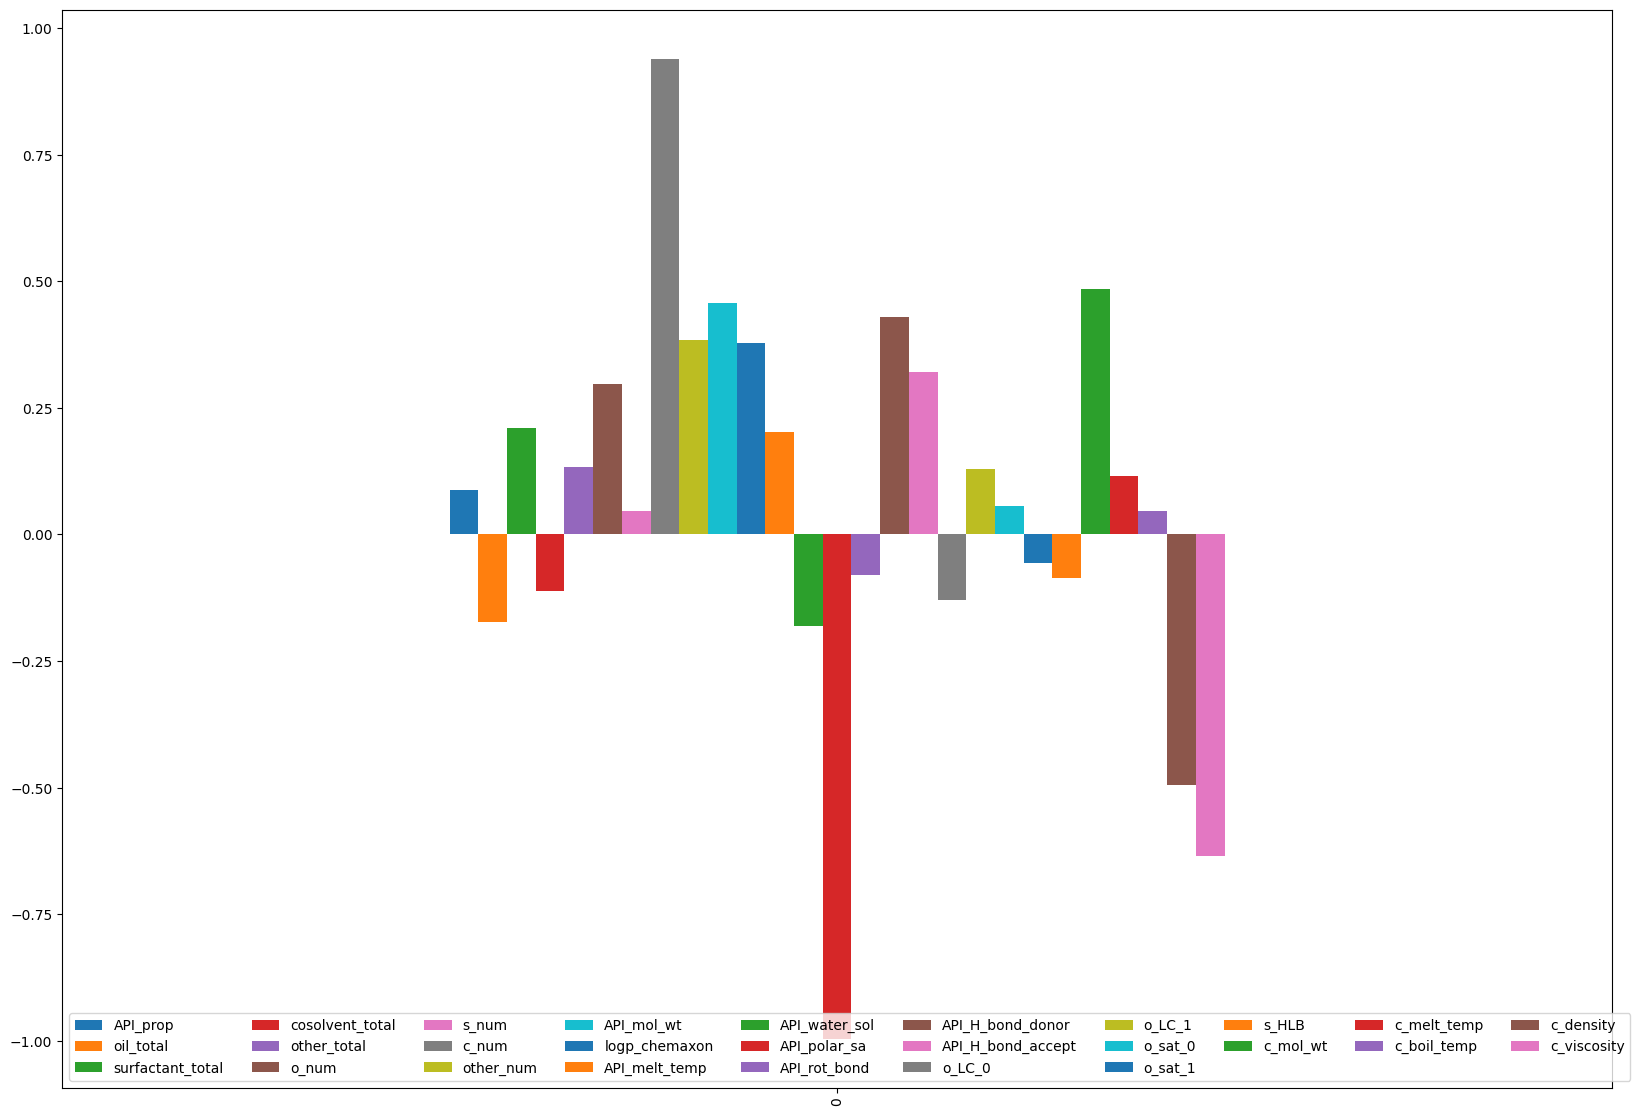

In [11]:
lr_coefs = pd.DataFrame(log_reg.named_steps['reg'].coef_, columns = X.columns.values)
lr_coefs.plot(kind='bar', figsize = (20, 14))
plt.legend(loc='lower left', ncol=10)
plt.show()

In [12]:
top5 = lr_coefs.abs().max().nlargest(5).index.to_list()
lr_coefs[top5].T

,0
API_polar_sa,-0.995672
c_num,0.939914
c_viscosity,-0.635459
c_density,-0.494467
c_mol_wt,0.483782


- **Important features**
    - drug surface area, decreasing probability of SEDDS formulation to progress
    - number of cosolvents use has positive impact
    - density of cosolvent negative and mol_wt positive

In [13]:
last5 = lr_coefs.abs().max().nsmallest(5).index.to_list()
lr_coefs[last5].T

,0
c_boil_temp,0.045772
s_num,0.046551
o_sat_0,0.056073
o_sat_1,-0.056073
API_rot_bond,-0.079496


- cosolvent boiling temperature, type of used oil and number of surfactants used seems to have insignificant impact on progression of SEDDS formulation

In [14]:
pca_logreg = classifiers.get('pca_logreg')
pca_logreg.fit(X_tr, y_tr).score(X_ts, y_ts)

/Users/potato/Library/Caches/pypoetry/virtualenvs/sedds-analysis-fO4BEvps-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.664179104477612

In [15]:
svm = classifiers.get('svm')
svm.fit(X_tr, y_tr).score(X_ts, y_ts)

/Users/potato/Library/Caches/pypoetry/virtualenvs/sedds-analysis-fO4BEvps-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.6940298507462687

In [16]:
dt = classifiers.get('dt_class')
dt.fit(X_tr, y_tr).score(X_ts, y_ts)

0.6343283582089553

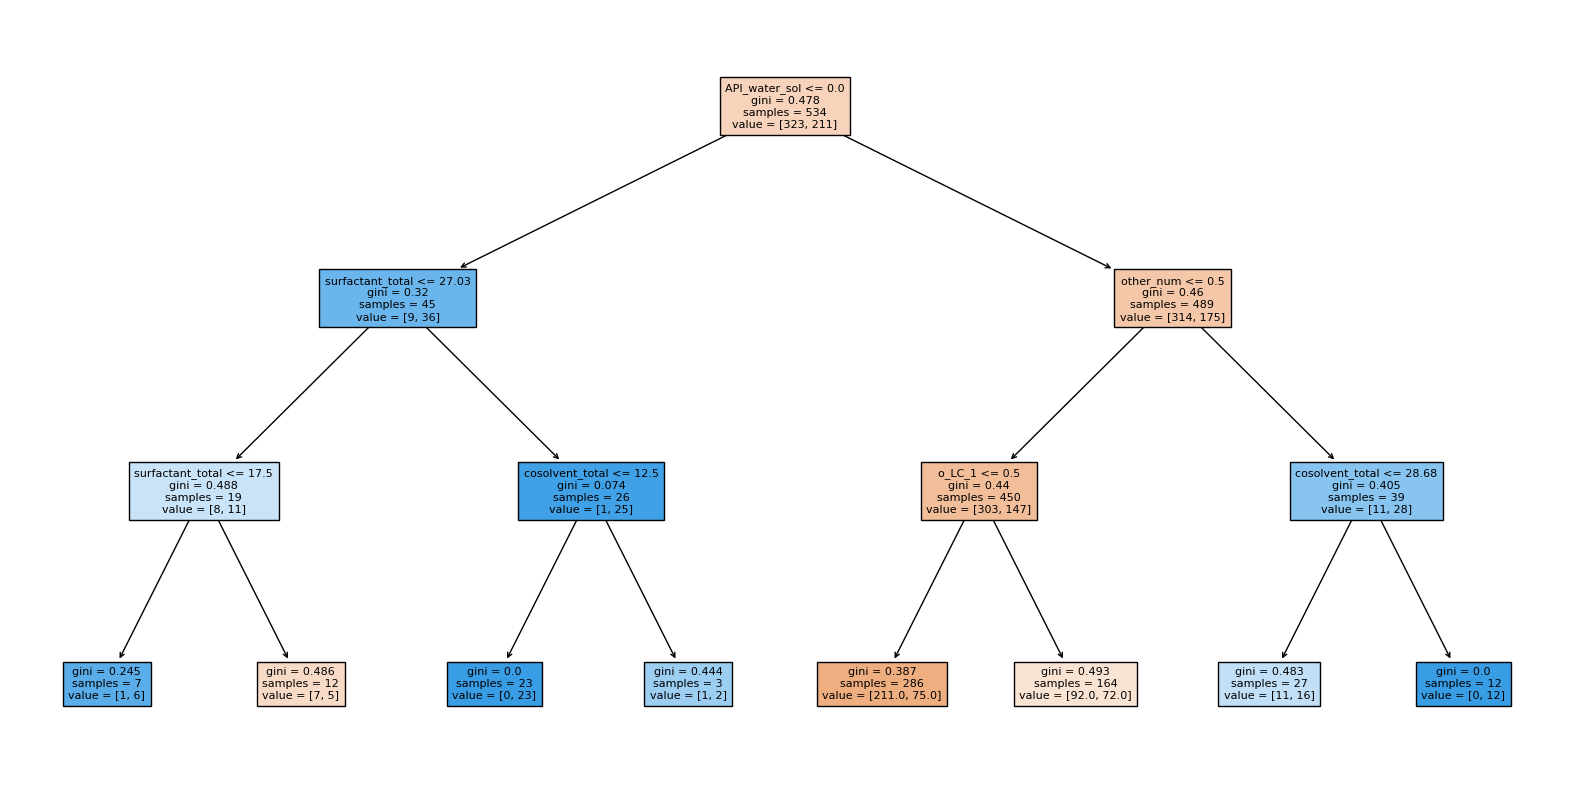

In [17]:
plt.figure(figsize=(20,10))
plot_tree(dt.named_steps['dt'], filled=True, feature_names=X.columns, fontsize=8)
plt.show()

- drug solubility determines the progression based on the amount of surfactant/cosolvent used.


#### CatBoost as a our katana
- CatBoost is able to "eat literally everything". It is is known for its robustness and can handle a wide range of data types without needing special preprocessing like one-hot encoding for categorical data.

In [18]:
catboost_model = classifiers.get('cb')
catboost_model.fit(X_tr, y_tr)
catboost_model.score(X_ts, y_ts)


Learning rate set to 0.232104
0:	learn: 0.6434190	total: 58ms	remaining: 1.39s
1:	learn: 0.6053797	total: 58.7ms	remaining: 675ms
2:	learn: 0.5721997	total: 59.3ms	remaining: 435ms
3:	learn: 0.5525835	total: 60.1ms	remaining: 315ms
4:	learn: 0.5277699	total: 60.7ms	remaining: 243ms
5:	learn: 0.5064310	total: 61.4ms	remaining: 194ms
6:	learn: 0.4883171	total: 62.1ms	remaining: 160ms
7:	learn: 0.4793571	total: 62.7ms	remaining: 133ms
8:	learn: 0.4695327	total: 63.3ms	remaining: 112ms
9:	learn: 0.4672152	total: 63.7ms	remaining: 95.5ms
10:	learn: 0.4512151	total: 64.2ms	remaining: 81.7ms
11:	learn: 0.4402904	total: 65.7ms	remaining: 71.2ms
12:	learn: 0.4324956	total: 66.2ms	remaining: 61.1ms
13:	learn: 0.4216031	total: 66.9ms	remaining: 52.5ms
14:	learn: 0.4142659	total: 67.4ms	remaining: 44.9ms
15:	learn: 0.4087008	total: 68ms	remaining: 38.2ms
16:	learn: 0.3996620	total: 68.7ms	remaining: 32.3ms
17:	learn: 0.3910043	total: 69.2ms	remaining: 26.9ms
18:	learn: 0.3867440	total: 69.8ms	rema

0.6940298507462687

- catboost is chosen as best performing model

# Feature engineering

## Drug Solubility-Excipient Content Interaction

- Quantify how much the solubility of the API could be enhanced by the presence and properties of the excipients.
- might predict the overall effectiveness of the drug formulation i.e. its ability to dissolve the drug efficiently

In [19]:
data_solulibility_impact = data.with_columns([
    ((data["API_water_sol"] * data["oil_total"]) + 
     (data["API_water_sol"] * data["surfactant_total"] * data["s_HLB"]) +
     (data["API_water_sol"] * data["cosolvent_total"])).alias("solubility_impact")
])

In [20]:
data_solulibility_impact.describe()

statistic,progressed,size,PDI,API_prop,oil_total,surfactant_total,cosolvent_total,other_total,o_num,s_num,c_num,other_num,cplx_minmax_norm,API_mol_wt,logp_chemaxon,API_melt_temp,API_water_sol,API_polar_sa,API_rot_bond,API_H_bond_donor,API_H_bond_accept,o_LC,o_sat,s_HLB,c_mol_wt,c_melt_temp,c_boil_temp,c_density,c_viscosity,solubility_impact
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,f64,f64,f64,f64,f64,f64,f64
"""count""","""668""",506.0,289.0,668.0,668.0,668.0,668.0,668.0,668.0,668.0,668.0,668.0,668.0,668.0,668.0,668.0,668.0,668.0,668.0,668.0,668.0,"""668""","""668""",668.0,668.0,668.0,668.0,668.0,668.0,668.0
"""null_count""","""0""",162.0,379.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""0""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",null,140.205658,0.250784,6.415936,35.014633,45.269371,12.147912,1.152695,1.368263,1.288922,0.646707,0.091317,0.174401,481.722534,4.733294,130.891464,0.057113,95.349953,8.296407,1.73503,4.547904,null,null,13.642815,78.044014,-42.598801,97.270958,0.582036,13.658234,40.84605
"""std""",null,304.983734,0.146898,6.055097,21.0464,20.49094,15.289106,6.349833,0.560316,0.625828,0.551164,0.308378,0.109052,229.726608,1.685694,48.424789,0.175672,74.825226,3.715382,1.995535,3.195637,null,null,2.526405,105.660721,47.233089,92.058823,0.472266,27.431568,141.909317
"""min""",null,7.2,0.02,0.06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.289993,-2.3,59.5,0.00011,6.48,0.0,0.0,2.0,null,null,0.0,0.0,-114.099998,0.0,0.0,0.0,0.020704
"""25%""",null,31.9,0.145,2.0,18.0,30.0,0.0,0.0,1.0,1.0,0.0,0.0,0.125,360.829987,3.64,80.5,0.00071,46.529999,6.0,0.0,3.0,null,null,13.0,0.0,-76.0,0.0,0.0,0.0,0.61731
"""50%""",null,76.529999,0.23,5.0,33.169998,44.0,8.0,0.0,1.0,1.0,1.0,0.0,0.125,406.473999,5.22,125.5,0.0122,52.599998,7.0,1.0,3.0,null,null,14.5,46.099998,-26.0,78.400002,0.8,1.1,6.109845
"""75%""",null,170.699997,0.32,8.5,50.34,61.5,19.34,0.0,2.0,2.0,1.0,0.0,0.25,500.423004,5.28,149.5,0.0234,117.68,11.0,2.0,6.0,null,null,15.0,134.199997,0.0,202.0,1.0,4.8,14.048667
"""max""",null,4964.0,0.949,52.700001,99.32,97.0,76.800003,68.040001,3.0,5.0,3.0,2.0,1.0,1202.609985,8.06,232.0,0.75,319.609985,18.0,12.0,17.0,null,null,16.9,600.0,32.5,261.200012,1.2,90.0,1041.780151


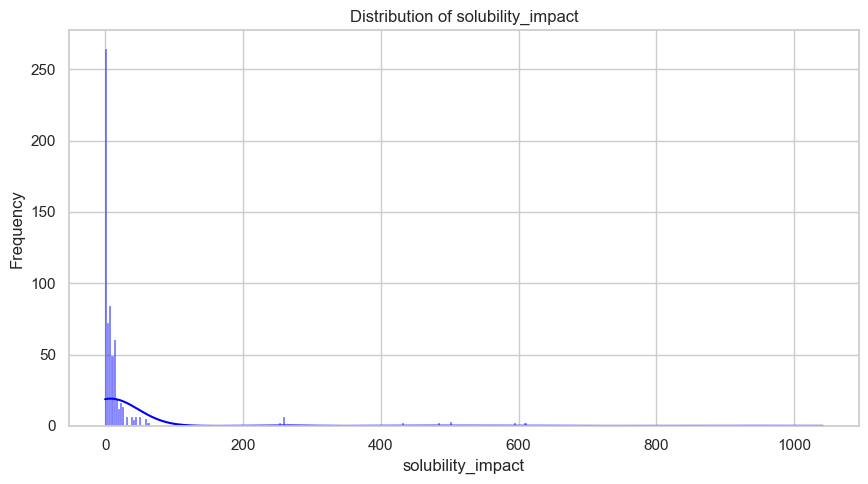

In [21]:
plot_utils.plot_histogram(features=["solubility_impact"], data=data_solulibility_impact)

- left skewed
- peak very close to 0

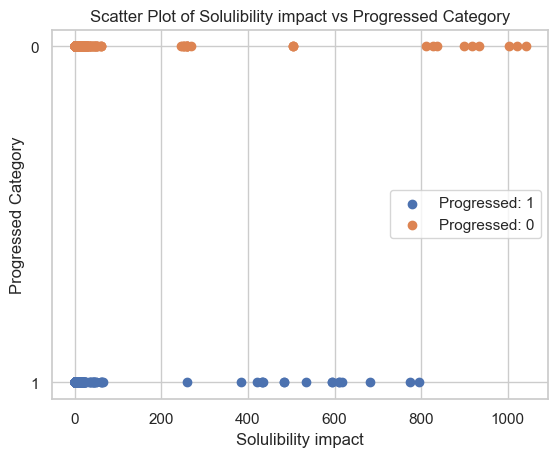

In [22]:
fig, ax = plt.subplots()

unique_categories = data_solulibility_impact['progressed'].unique().to_list()
list(map(lambda category: ax.scatter(
    data_solulibility_impact.filter(pl.col("progressed") == category)["solubility_impact"].to_numpy(), 
    [category] * len(data_solulibility_impact.filter(pl.col("progressed") == category)), 
    label=f'Progressed: {category}'
), unique_categories))

ax.set_xlabel('Solulibility impact')
ax.set_ylabel('Progressed Category')
ax.set_title('Scatter Plot of Solulibility impact vs Progressed Category')
ax.legend()
plt.show()

- bigger values might lead to not progression of formulation 

In [23]:
from sklearn.model_selection import train_test_split

# X = data_solulibility_impact.drop([target] + sedds_features).to_pandas()
X = data_solulibility_impact.drop([target] + sedds_features).to_dummies(cs.categorical()).to_pandas()
y = data_solulibility_impact.select(target).to_pandas()

X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.20, random_state=42)

In [25]:
# catboost_model = CatBoostClassifier(verbose=0, random_state=42, cat_features=cat_features)
catboost_model = CatBoostClassifier(verbose=0, random_state=42)

catboost_model.fit(X_tr, y_tr, plot=True)
catboost_model.score(X_ts, y_ts)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.7164179104477612

0.6716417910447762


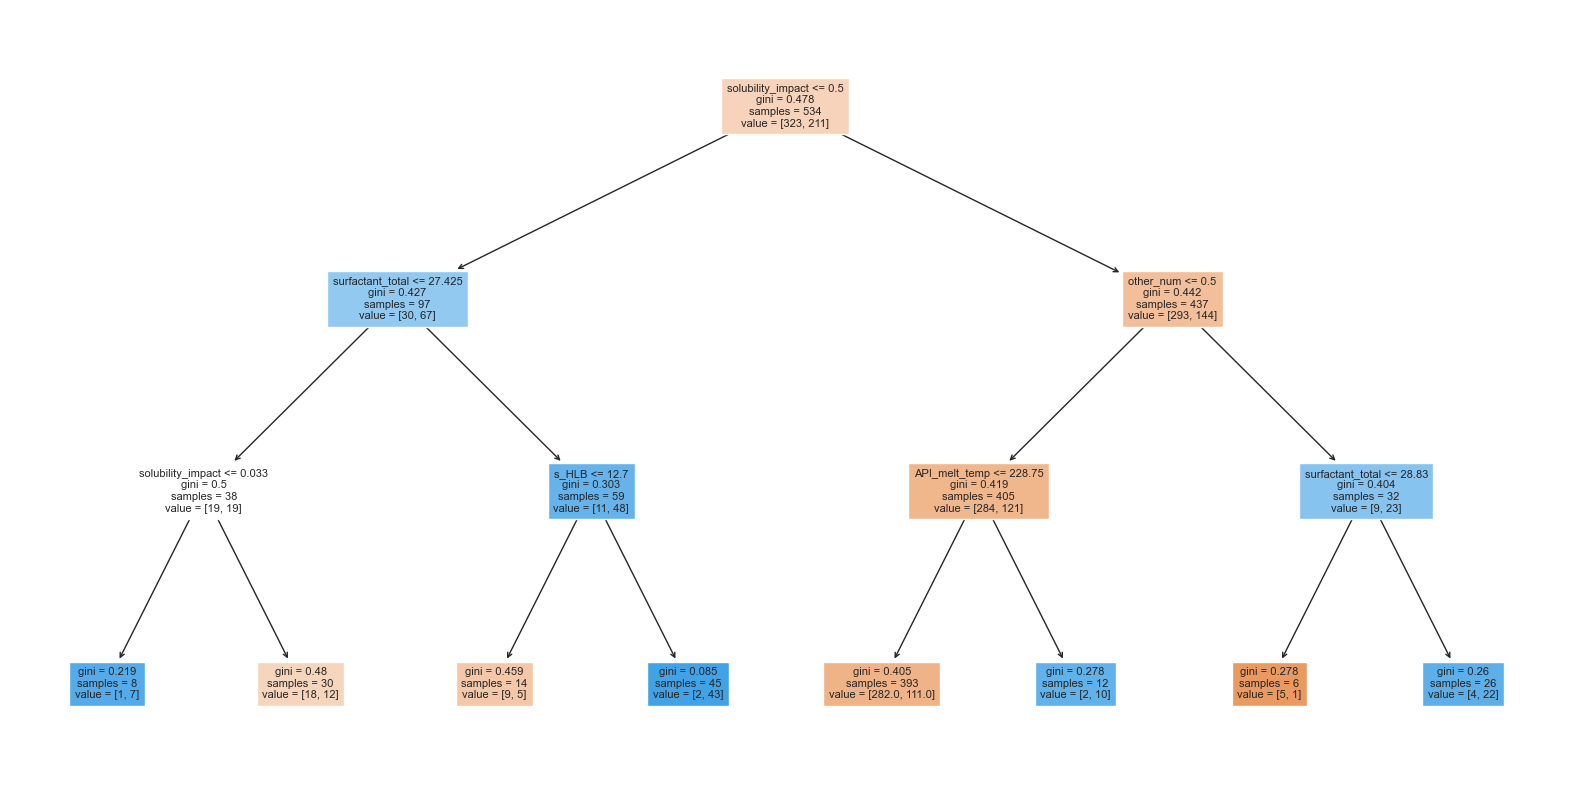

In [26]:
dt = classifiers.get('dt_class')
dt.fit(X_tr, y_tr).score(X_ts, y_ts)
print(dt.score(X_ts, y_ts))
plt.figure(figsize=(20,10))
plot_tree(dt.named_steps['dt'], filled=True, feature_names=X.columns, fontsize=8)
plt.show()

### Interaction of the lipophilicity of the drug with the hydrophilic-lipophilic balance of the surfactants

- how well the surfactants can help solubilize and stabilize the drug
- is used surfactant suitable for the used drug?


In [27]:
# NOTE: features commented out did not improve our model
data_surfactants = data.with_columns([
    (data["logp_chemaxon"] * data["s_HLB"]).alias("logp_chemaxon_s_HLB_interaction")
])

# data_surfactants = data.with_columns([
#     ((data["API_water_sol"] * data["oil_total"]) + 
#      (data["API_water_sol"] * data["surfactant_total"] * data["s_HLB"]) +
#      (data["API_water_sol"] * data["cosolvent_total"])).alias("solubility_impact")
# ])

# data_surfactants = data.with_columns([
#     (data["surfactant_total"] * data["s_HLB"]).alias("surfactant_effectiveness")
# ])

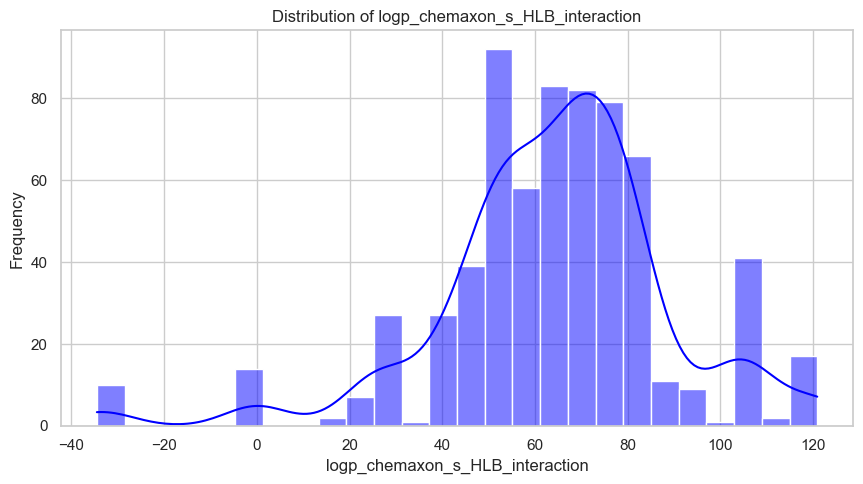

In [28]:
plot_utils.plot_histogram(features=["logp_chemaxon_s_HLB_interaction"], data=data_surfactants)

- centered around 70

In [29]:
from sklearn.model_selection import train_test_split

X = data_surfactants.drop([target] + sedds_features).to_dummies(cs.categorical()).to_pandas()
y = data_surfactants.select(target).to_pandas()

X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.20, random_state=42)

0.6343283582089553


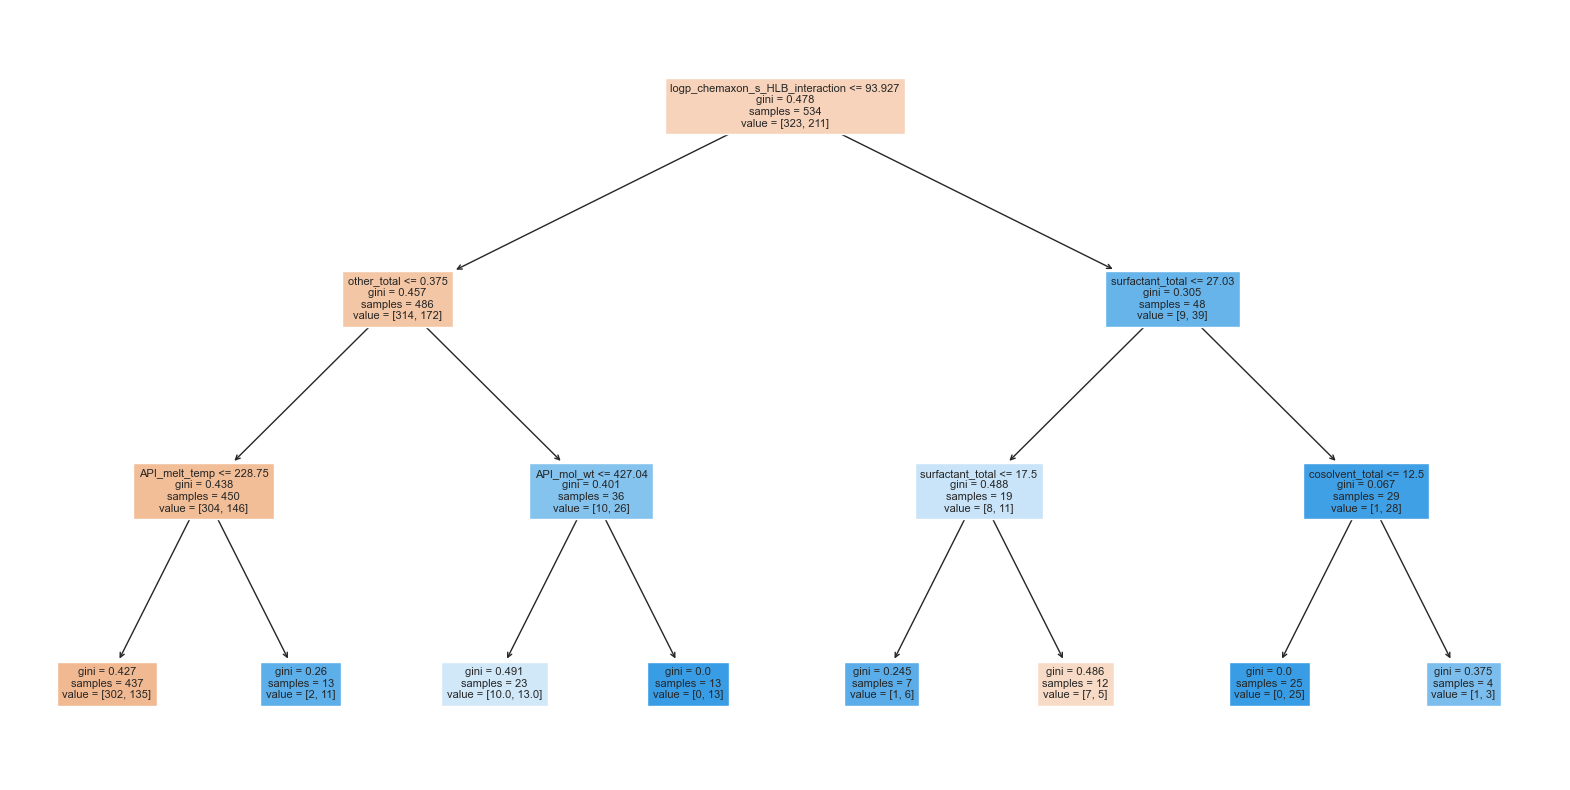

In [30]:
dt = classifiers.get('dt_class')
dt.fit(X_tr, y_tr).score(X_ts, y_ts)
print(dt.score(X_ts, y_ts))
plt.figure(figsize=(20,10))
plot_tree(dt.named_steps['dt'], filled=True, feature_names=X.columns, fontsize=8)
plt.show()

In [31]:
catboost_model.fit(X_tr, y_tr, plot=True)
catboost_model.score(X_ts, y_ts)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.7014925373134329

In [32]:
# NOTE: We fit the best model on all data
# Catboost model with interaction feature was chosen as best performing and used for the API.
# catboost_model.fit(X, y)

#### Save the best model

We will save the best performing model to a file for future use.


In [33]:
# pickle.dump(catboost_model, open('../../models/progressed_model.pkl', 'wb'))